In [14]:
from typing import Callable, Optional
import random
import pickle
import os
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# QPE implementation

GPU: https://pennylane.ai/install#high-performance-computing-and-gpus

In [4]:
GPU_SIMULATION = True
num_shots = 1024
if GPU_SIMULATION:
    dev = qml.device("lightning.gpu", shots = num_shots) #wires=num_qubits
else:
    dev = qml.device("default.qubit", shots = num_shots) # None shots means analytical calculation

In [5]:
@qml.qnode(dev)
def circuit_qpe(
    estimation_wires: list[int],
    q_register: list[int],
    state_prep: Callable[[list[int]], None],
    controlled_unitary: Callable[..., None],
    **kargs
):
    """
    Quantum Phase Estimation (QPE) circuit.

    Args:
        estimation_wires: List of qubits used to estimate the phase.
        q_register: List of qubits holding the eigenstate of the unitary.
        state_prep: Function that prepares the initial state |u⟩ on q_register.
        controlled_unitary: Function that applies controlled-U^{2^i}.
        **kargs: Additional arguments passed to controlled_unitary.

    Returns:
        Probability distribution over estimation_wires after QPE.
    """
    # initial state
    state_prep(q_register)

    for wire in estimation_wires:
        qml.Hadamard(wires=wire)

    for i, control in enumerate(reversed(estimation_wires)):
        controlled_unitary(control, q_register, 2**i, **kargs)

    qml.adjoint(qml.QFT)(wires=estimation_wires)

    return qml.probs(wires=estimation_wires)

In [6]:
def binary_string_to_decimal(binary_string: str) -> float:
    # binary_string represent the bits of the decimal number in format 0.i_1i_2...i_n
    # where binary_string is i_1i_2...i_n
    res = 0
    for i, bit in enumerate(binary_string):
        res += float(bit)*2**(-i-1)

    return res

### Example

Computing the phase $\theta$ for $e^{i2\pi/5}$, which is the eigenvalue of

$U = \begin{bmatrix}
1 & 0 \\
0 & e^{i2\pi/5}
\end{bmatrix}$

corresponding to the eigenvector $|1\rangle$. The output should be $\theta = 1/5$.

In [7]:
num_digits = 6

results = circuit_qpe(
    estimation_wires=range(num_digits),
    q_register = [num_digits],
    state_prep = lambda wires: qml.X(wires[0]),
    controlled_unitary = lambda control, q_register, k: qml.ControlledPhaseShift(2*k * np.pi / 5, wires=[control]+q_register)
)

results_ordered = [(f"0.{x:0{num_digits}b}", results[x]) for x in range(len(results))]
results_ordered.sort(key=lambda tup: tup[1], reverse=True)

print(results_ordered[0])
print(binary_string_to_decimal(results_ordered[0][0][2:]))

('0.001101', np.float64(0.869140625))
0.203125


Notice the result is $\approx 0.2 = 1/5$.

# Application: Ground state energy for Hydrogen molecule (H2)

## Hamiltonian for H2

Reference: https://dojo.qulacs.org/en/latest/notebooks/7.1_quantum_phase_estimation_detailed.html#Example:-Calculation-of-the-ground-state-energy-of-the-hydrogen-molecular-Hamiltonian-using-the-quantum-phase-estimation-algorithm

The Hamiltonian of the Hydrogen molecule is written in the second quantized, expressed in terms of creation and annihilation operators acting on some basis of molecular orbitals. Then, using Bravyi-Kitaev transformation, this Hamiltonian is mapped into qubits using the minimial STO-6G basis, getting the 4-qubit Hamiltonian
$$
H = f_0 I + f_1Z_0 + f_2 Z_1 + f_3Z_2 + f_1Z_0Z_1 \\
+ f_4Z_0Z_2 + f_5Z_1Z_3 + f_6X_0Z_1X_2 + f_6Y_0Z_1Y_2 \\
+ f_7Z_0Z_1Z_2 + f_4Z_0Z_2Z_3 + f_3 Z_1Z_2Z_3 \\
+ f_6 X_0 Z_1 X_2 Z_3 + f_6 Y_0 Z_1 Y_2 Z_3 + f_7Z_0Z_1Z_2Z_3,
$$
where the values $f_i$ depend on the fixed bond length of the molecule. Noticing this Hamiltonian stabilizes qubits 1 and 3 when they start in $|0\rangle$ (as in Hartree-Fock state), we can obtain a reduced two-qubit Hamiltonian:
$$
H = \sum_{i} g_i H_i = g_0I + g_1Z_0 + g_2Z_1 + g_3Z_0Z_1 + g_4Y_0Y_1 + g_5X_0X_1,
$$
where the $g_i$ values are function of the $f_i$ values.

We need to decompose $U=e^{-i\tau H}$ into a quantum circuit, where $\tau$ is a constant such that $[E_{\text{min}}, E_{\text{max}}]$ is shrinked to $[0, 2\pi]$. Since $g_0I$ and $g_3Z_0Z_1$ conmute with the other terms:
$$
e^{-i\tau H} = \exp(-i\tau \sum_{i} g_i H_i) = \exp[-i\tau g_0I]\exp[-i\tau g_3Z_0Z_1]\exp[-i\tau H_{eff}],
$$
$$
H_{eff}:= g_1Z_0 + g_2Z_1+ g_4Y_0Y_1 + g_5X_0X_1.
$$
Use Trotterization:
$$
U_{eff}:=\exp[-i\tau H_{eff}] \approx \left(\prod_{i=1,2,4, 5}\exp[-i\tau H_i/N ]\right)^N.
$$
The exponentials in the right-hand side are of the form $\exp(i\theta P)$, where $P$ is a Pauli matrix, and it is easy to implement it in a quantum circuit.

### Finding eigenvalues of $H$ and $H_{\text{eff}}$ classically

In [7]:
def construct_H_eff(coeff: list[float]) -> np.ndarray:
    c1, c2, c3, c4 = coeff

    # Pauli matrices and the identity matrix
    X = np.array([[0, 1], [1, 0]], dtype=complex)
    Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    Z = np.array([[1, 0], [0, -1]], dtype=complex)
    I = np.eye(2, dtype=complex)

    # c1 * Z_0
    term1 = c1 * np.kron(Z, I)

    # c2 * Z_1
    term2 = c2 * np.kron(I, Z)

    # c3 * Y_0 Y_1
    term3 = c3 * np.kron(Y, Y)

    # c4 * X_0 X_1
    term4 = c4 * np.kron(X, X)

    return term1 + term2 + term3 + term4



def construct_hamiltonian(coeff: list[float]) -> np.ndarray:
    g0, g1, g2, g3, g4, g5 = coeff

    # Pauli matrix Z
    Z = np.array([[1, 0], [0, -1]], dtype=complex)

    # g0 * I
    term1 = g0 * np.eye(4, dtype=complex)

    # g3 * Z_0 Z_1
    term2 = g3 * np.kron(Z, Z)

    # H_eff
    H_eff = construct_H_eff([g1, g2, g4, g5])

    return term1 + term2 + H_eff

Table of coefficientes for different internuclear distance

In [8]:
table_coeffs_path = "/content/drive/MyDrive/Miguel R - Thesis MSc/table_coeffs.csv"
coeffs_df = pd.read_csv(table_coeffs_path)
coeffs_df.head()

,nuclear_dist,I,Z0,Z1,Z0Z1,X0X1,Y0Y1,t0,ordering,trotter_error
0,0.20,2.8489,0.5678,-1.4508,0.6799,0.0791,0.0791,1.50,Z0·X0X1·Z1·Y0Y1,0.0124
1,0.25,2.1868,0.5449,-1.2870,0.6719,0.0798,0.0798,1.59,Z0·Y0Y1·Z1·X0X1,0.0521
2,0.30,1.7252,0.5215,-1.1458,0.6631,0.0806,0.0806,1.77,X0X1·Z0·Y0Y1·Z1,0.0111
3,0.35,1.3827,0.4982,-1.0226,0.6537,0.0815,0.0815,2.08,Z0·X0X1·Z1·Y0Y1,0.0368
4,0.40,-0.2047,0.4754,-0.9145,0.6438,0.0825,0.0825,2.10,Z0·X0X1·Z1·Y0Y1,0.0088


In [ ]:
coeffs_df["ordering"].iloc[0].split("·"), coeffs_df["ordering"].iloc[0]

(['Z0', 'X0X1', 'Z1', 'Y0Y1'], 'Z0·X0X1·Z1·Y0Y1')

Computing the ground state energy for internuclear distance $R=0.70$

In [11]:
coeffs_eg = coeffs_df.loc[10]
coeffs_eg

,10
nuclear_dist,0.7
I,-0.4584
Z0,0.3593
Z1,-0.4826
Z0Z1,0.5818
X0X1,0.0896
Y0Y1,0.0896
t0,0.64
ordering,Z0·Y0Y1·Z1·X0X1
trotter_error,0.0171


In [12]:
H_eff = construct_H_eff(coeffs_eg[["Z0", "Z1", "Y0Y1", "X0X1"]])
H = construct_hamiltonian(coeffs_eg[["I", "Z0", "Z1", "Z0Z1", "Y0Y1", "X0X1"]])

In [ ]:
eigs_H = np.linalg.eigvals(H)
eigs_H_eff = np.linalg.eigvals(H_eff)

print("H")
print("Eigenvalues:", eigs_H)
print("Minimum:", np.min(eigs_H))
print("-"*10)
print("H_eff")
print("Eigenvalues:", eigs_H_eff)
print("Minimum:", np.min(eigs_H_eff))

H
Eigenvalues: [-1.90096027e+00+0.j -1.79439726e-01+0.j  1.00000000e-04+0.j
  2.46700000e-01+0.j]
Minimum: (-1.900960274408618+0j)
----------
H_eff
Eigenvalues: [-0.86076027+0.j  0.86076027+0.j -0.1233    +0.j  0.1233    +0.j]
Minimum: (-0.8607602744086181+0j)


Notice:

In [ ]:
coeffs_eg["I"] - coeffs_eg["Z0Z1"] + np.min(eigs_H_eff) # -> np.min(eigs_H)

np.complex128(-1.900960274408618+0j)

### Computing the exact energy surface

In [9]:
energy_surface = np.zeros(len(coeffs_df))
for idx, coeffs in coeffs_df.iterrows():
    hamiltonian = construct_hamiltonian(coeffs[["I", "Z0", "Z1", "Z0Z1", "Y0Y1", "X0X1"]]) # construct_H_eff(coeffs[["Z0", "Z1", "Y0Y1", "X0X1"]])
    eigs_H = np.linalg.eigvals(hamiltonian)
    energy_surface[idx] = np.min(eigs_H).real

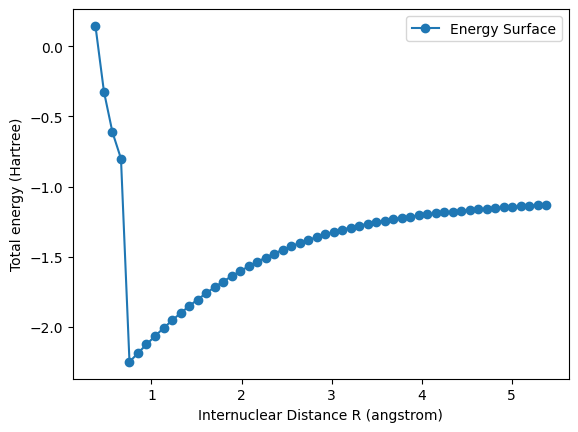

In [10]:
plt.plot(coeffs_df["nuclear_dist"]/0.52917721067121, energy_surface, marker="o", label="Energy Surface")
plt.xlabel("Internuclear Distance R (angstrom)")
plt.ylabel("Total energy (Hartree)")
plt.legend()
plt.show()

### Finding eigenvalues of $H$ with Quantum Phase Estimation algorithm

Function that computes the controlled $U^{2^j}$ gates for the QPE circuit, where $U=\exp(-iH\tau)$ is computed with the Trotter approximation.

In [11]:
def ctrl_RZZ(phi: float, control: int, target_wires: list[int]):
    qml.CNOT(wires=target_wires)
    qml.CRZ(phi=phi, wires=[control, target_wires[1]])
    qml.CNOT(wires=target_wires)

def ctrl_RXX(phi: float, control: int, target_wires: list[int]):
    qml.Hadamard(wires=target_wires[0])
    qml.Hadamard(wires=target_wires[1])
    ctrl_RZZ(phi=phi, control=control, target_wires=target_wires)
    qml.Hadamard(wires=target_wires[0])
    qml.Hadamard(wires=target_wires[1])

def ctrl_RYY(phi: float, control: int, target_wires: list[int]):
    qml.adjoint(qml.S)(wires=target_wires[0])
    qml.adjoint(qml.S)(wires=target_wires[1])
    ctrl_RXX(phi=phi, control=control, target_wires=target_wires)
    qml.S(wires=target_wires[0])
    qml.S(wires=target_wires[1])

In [12]:
def string_to_operator(operator: str, phi: float, control: int, target_wires: list[int]):
    # apply controlled-RZ, controlled-RXX or controlled-RYY, according to parameter ``operator``
    if operator == "Z0" or operator == "Z1":
        target = target_wires[0] if operator[1] == "0" else target_wires[1]
        qml.CRZ(phi=phi, wires=[control, target])
    elif operator == "Y0Y1":
        ctrl_RYY(phi=phi, control=control, target_wires=target_wires)
    elif operator == "X0X1":
        ctrl_RXX(phi=phi, control=control, target_wires=target_wires)


def controlledHydrogenUnitary(
    control: int,
    target_wires: list[int],
    k: int,
    tau: float,
    trotter_steps: int,
    coeff: dict[str, float],
    add_ZZ: bool = False,
    ordering: Optional[list[str]] = None
):
    """Apply the controlled-exp(-i*tau*k*H), where H is explained above.
    The order of terms in H is specified in the ``ordering`` parameter, e.g.,
    ["Z0", "X0X1", "Z1", "Y0Y1"]. Only the terms in this example list are considered.
    These strings are keys from coeff when it is a dictionary
    """

    # we may omit exp(-i*tau*g_0 I) and add tau*g_0 to the eigenvalue obtained

    # controlled-RZZ
    if add_ZZ:
        ctrl_RZZ(phi=2 * coeff["Z0Z1"] * tau * k, control=control, target_wires=target_wires)

    # default operator ordering
    if ordering is None:
        ordering = ["Z0", "Y0Y1", "Z1", "X0X1"]

    # trotterization for U_eff^k
    for _ in range(trotter_steps):
        for operator in ordering:
            string_to_operator(operator, 2 * tau * k * coeff[operator] / trotter_steps, control, target_wires)

### Example of how incrementing the Trotter steps gives more accuracy:

- Initial state with sufficient overlap with the ground state: the Hartree-Fock state which is $|01\rangle$.

In [ ]:
tau = coeffs_eg["t0"]
coeff = coeffs_eg[["I", "Z0", "Z1", "Z0Z1", "Y0Y1", "X0X1"]]

In [ ]:
COMPUTE_WORKLOAD = False

if COMPUTE_WORKLOAD:
    eigs = []

    max_trotter_steps = 100
    num_digits = 12

    for trotter_steps in tqdm(range(1, max_trotter_steps+1)):
        results = circuit_qpe(
            estimation_wires=range(num_digits),
            q_register = [num_digits, num_digits+1],
            state_prep = lambda wires: qml.X(wires[0]),
            controlled_unitary = controlledHydrogenUnitary,
            tau = tau,
            trotter_steps = trotter_steps,
            coeff = coeff,
        )

        results_ordered = [(f"0.{x:0{num_digits}b}", results[x]) for x in range(len(results))]
        results_ordered.sort(key=lambda tup: tup[1], reverse=True)

        phase = binary_string_to_decimal(results_ordered[0][0][2:])

        estimated_eig = -2*np.pi*phase/tau

        eigs.append(estimated_eig)

In [ ]:
pickle_path = "/content/drive/MyDrive/Miguel R - Thesis MSc/eigs_results.pkl"

# Check if the file already exists
if os.path.exists(pickle_path):
    # Load previously computed eigenvalues
    with open(pickle_path, "rb") as f:
        eigs = pickle.load(f)
    print("Eigenvalues loaded from pickle file.")
else:
    # Save eigenvalues to pickle for future use
    with open(pickle_path, "wb") as f:
        pickle.dump(eigs, f)

    print("Eigenvalues computed and saved to pickle file.")

Eigenvalues loaded from pickle file.


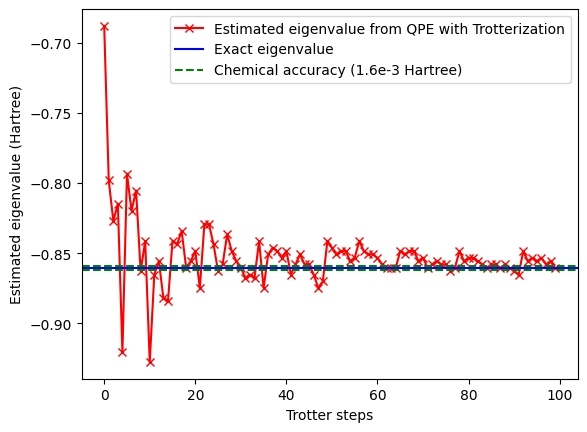

In [ ]:
exact_eig = min(eigs_H_eff).real
plt.plot(eigs, color="red", marker="x", label="Estimated eigenvalue from QPE with Trotterization")
plt.xlabel("Trotter steps")
plt.ylabel("Estimated eigenvalue (Hartree)")
plt.axhline(y=exact_eig, color='b', linestyle='-', label='Exact eigenvalue')
# plot chemical accuracy line

chemical_accuracy = 1.6e-3 # Hartree
plt.axhline(y=exact_eig + chemical_accuracy, color='g', linestyle='--', label='Chemical accuracy (1.6e-3 Hartree)')
plt.axhline(y=exact_eig - chemical_accuracy, color='g', linestyle='--')
plt.legend()
plt.show()

### Top results from QPE with the maximum Trotter steps

Only top results with the 90% of the probability distribution

In [ ]:
if COMPUTE_WORKLOAD:
    cumsum = np.cumsum([tup[1] for tup in results_ordered])
    for i, s in enumerate(cumsum):
        if s >= 0.9:
            cumsum_i = i
            print(i)
            break

    results_ordered = results_ordered[:cumsum_i + 1]
    results_ordered.sort(key=lambda tup: tup[0])

    plt.figure(figsize=(15, 8))
    plt.bar([tup[0] for tup in results_ordered], [tup[1] for tup in results_ordered])
    plt.xlabel("phase")
    plt.ylabel("probability")
    plt.xticks(rotation="vertical")
    plt.subplots_adjust(bottom=0.3)
    plt.show()

### Energy surface with QPE

In [13]:
ordering = ["Z0", "Y0Y1", "Z1", "X0X1"]

In [15]:
trotter_steps = 10
num_digits = 18

retries = 1
energy_surface_qpe = np.zeros((retries, len(coeffs_df)))

random.seed(7)

for idx, coeffs_row in tqdm(coeffs_df.iterrows(), total=len(coeffs_df)):
    tau = coeffs_row["t0"]
    coeff = coeffs_row[["I", "Z0", "Z1", "Z0Z1", "Y0Y1", "X0X1"]]

    for k in range(retries):
        results = circuit_qpe(
            estimation_wires=range(num_digits),
            q_register = [num_digits, num_digits+1],
            state_prep = lambda wires: qml.X(wires[0]),
            controlled_unitary = controlledHydrogenUnitary,
            tau = tau,
            trotter_steps = trotter_steps,
            coeff = coeff,
            add_ZZ = True,  # add controlled-RZZ term
            ordering = random.sample(ordering, len(ordering)) #coeffs_row["ordering"].split("·")
        )

        max_prob_result = results.argmax()
        max_prob_result_binary = f"{max_prob_result:0{num_digits}b}"
        phase = binary_string_to_decimal(max_prob_result_binary)
        estimated_eig = -2*np.pi*phase/tau + coeffs_row["I"]

        energy_surface_qpe[k, idx] = estimated_eig


100%|██████████| 54/54 [00:47<00:00,  1.13it/s]


In [ ]:
# prompt: save also the energy_surface_qpe data in a pickle file, the same way I did for the eigs variable

pickle_path_qpe = "/content/drive/MyDrive/Miguel R - Thesis MSc/energy_surface_qpe.pkl"

# Check if the file already exists
if os.path.exists(pickle_path_qpe):
    # Load previously computed energy surface
    with open(pickle_path_qpe, "rb") as f:
        energy_surface_qpe = pickle.load(f)
    print("Energy surface QPE loaded from pickle file.")
else:
    # Save energy surface QPE to pickle for future use
    with open(pickle_path_qpe, "wb") as f:
        pickle.dump(energy_surface_qpe, f)

    print("Energy surface QPE computed and saved to pickle file.")

Energy surface QPE computed and saved to pickle file.


In [17]:
outliers = (energy_surface - energy_surface_qpe[0]).__abs__() > 0.3
energy_surface[outliers]

array([-1.42492976, -1.40158   , -1.35945478, -1.3404246 , -1.30650457,
       -1.24179828, -1.18421584, -1.16671926, -1.16146412, -1.15206627,
       -1.14765032, -1.14356074, -1.13966424, -1.1286725 ])

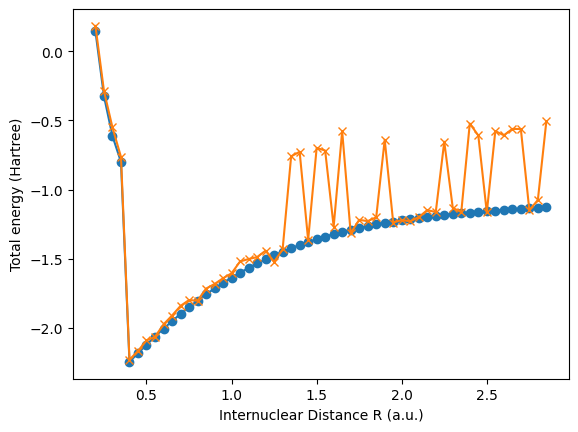

In [21]:
plt.plot(coeffs_df["nuclear_dist"], energy_surface, marker="o", label="Exact energy Surface")
for k in range(retries):
    plt.plot(coeffs_df["nuclear_dist"], energy_surface_qpe[k], marker="x", label=f"Energy Surface from QPE with Trotterization (retry {k+1})")

#plt.plot(coeffs_df["nuclear_dist"], energy_surface_qpe, marker="x", label="Energy Surface from QPE with Trotterization")
plt.xlabel("Internuclear Distance R (a.u.)")
plt.ylabel("Total energy (Hartree)")
#plt.legend()
plt.show()

In [19]:
coeffs_df.iloc[outliers]

,nuclear_dist,I,Z0,Z1,Z0Z1,X0X1,Y0Y1,t0,ordering,trotter_error
23,1.35,-0.5706,0.2123,-0.1077,0.4660,0.1100,0.1100,9.81,Z0·X0X1·Z1·Y0Y1,0.0694
24,1.40,-0.5707,0.2048,-0.0929,0.4588,0.1116,0.1116,9.93,Z0·X0X1·Z1·Y0Y1,0.0755
26,1.50,-0.5693,0.1908,-0.0666,0.4451,0.1149,0.1149,10.20,Z1·X0X1·Z0·Y0Y1,0.0885
27,1.55,-0.5679,0.1843,-0.0549,0.4386,0.1165,0.1165,9.83,Z0·X0X1·Z1·Y0Y1,0.0917
29,1.65,-0.5643,0.1723,-0.0342,0.4262,0.1196,0.1196,8.24,X0X1·Z0·Y0Y1·Z1,0.0488
34,1.90,-0.5516,0.1472,0.0052,0.3992,0.1270,0.1270,1.09,X0X1·Z0·Z1·Y0Y1,0.0017
41,2.25,-0.5310,0.1221,0.0397,0.3692,0.1359,0.1359,11.50,X0X1·Z1·Z0·Y0Y1,0.0946
44,2.40,-0.5223,0.1142,0.0495,0.3586,0.1392,0.1392,10.10,X0X1·Z1·Z0·Y0Y1,0.0334
45,2.45,-0.5195,0.1119,0.0523,0.3553,0.1402,0.1402,11.20,Z0·Z1·X0X1·Y0Y1,0.0663
47,2.55,-0.5141,0.1078,0.0572,0.3491,0.1422,0.1422,11.00,Z0·Z1·X0X1·Y0Y1,0.0550


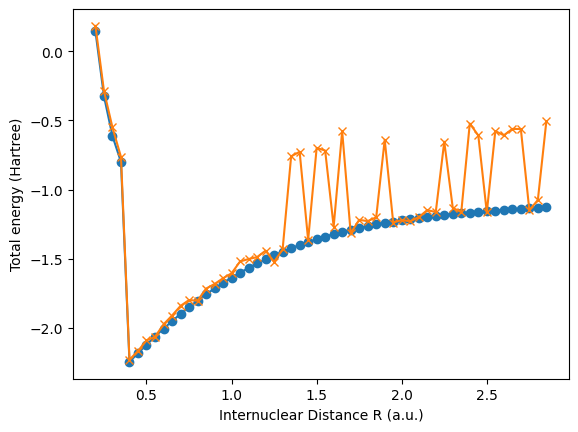

In [22]:
plt.plot(coeffs_df["nuclear_dist"], energy_surface, marker="o", label="Exact energy Surface")
plt.plot(coeffs_df["nuclear_dist"], energy_surface_qpe.min(axis=0), marker="x", label=f"Energy Surface from QPE with Trotterization (retry {k+1})")

#plt.plot(coeffs_df["nuclear_dist"], energy_surface_qpe, marker="x", label="Energy Surface from QPE with Trotterization")
plt.xlabel("Internuclear Distance R (a.u.)")
plt.ylabel("Total energy (Hartree)")
#plt.legend()
plt.show()

## Relation between the 4-qubit Hamiltonian and the 2-qubit Hamiltonian

Verification that the minimum eigenvalue of the 4-qubit Hamiltonian is the same as the 2-qubit Hamiltonian (in progress)

In [ ]:
def kron4(a: np.ndarray, b: np.ndarray, c: np.ndarray, d: np.ndarray) -> np.ndarray:
    # Tensor product of four matrices
    return np.kron(np.kron(np.kron(a, b), c), d)

def construct_H_complete(coeff: list[float]) -> np.ndarray:
    # Pauli matrices and the identity matrix
    X = np.array([[0, 1], [1, 0]], dtype=complex)
    Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    Z = np.array([[1, 0], [0, -1]], dtype=complex)
    I = np.eye(2, dtype=complex)

    H = np.zeros((16, 16), dtype=complex)

    H += coeff[0] * kron4(I, I, I, I)
    H += coeff[1] * kron4(Z, I, I, I)
    H += coeff[2] * kron4(I, Z, I, I)
    H += coeff[3] * kron4(I, I, Z, I)
    H += coeff[1] * kron4(Z, Z, I, I)
    H += coeff[4] * kron4(Z, I, Z, I)
    H += coeff[5] * kron4(I, Z, I, Z)
    H += coeff[6] * kron4(X, Z, X, I)
    H += coeff[6] * kron4(Y, Z, Y, I)
    H += coeff[7] * kron4(Z, Z, Z, I)
    H += coeff[4] * kron4(Z, I, Z, Z)
    H += coeff[3] * kron4(I, Z, Z, Z)
    H += coeff[6] * kron4(X, Z, X, Z)
    H += coeff[6] * kron4(Y, Z, Y, Z)
    H += coeff[7] * kron4(Z, Z, Z, Z)

    return H

In [ ]:
coeff_fs = [
    -0.81261, 0.171201, 0.16862325, -0.2227965, 0.171201,
    0.12054625, 0.17434925, 0.04532175, 0.04532175,
    0.165868, 0.12054625, -0.2227965,
    0.04532175, 0.04532175, 0.165868
    ]
coeff_gs = np.zeros(6)

coeff_gs[0] = coeff_fs[0] + coeff_fs[2] + coeff_fs[5]
coeff_gs[1] = 2*coeff_fs[1] + coeff_fs[4]
coeff_gs[2] = 2*coeff_fs[3]
coeff_gs[3] = 2*(coeff_fs[4] + coeff_fs[7])
coeff_gs[4] = 2*coeff_fs[6]
coeff_gs[5] = 2*coeff_fs[6]
coeff_gs

array([-0.5234405,  0.513603 , -0.445593 ,  0.4330455,  0.3486985,
        0.3486985])

In [ ]:
coeff_fs = np.random.rand(8)
coeff_gs = np.zeros(6)

coeff_gs[0] = coeff_fs[0] + coeff_fs[2] + coeff_fs[5]
coeff_gs[1] = 2*coeff_fs[1] + coeff_fs[4]
coeff_gs[2] = 2*coeff_fs[3]
coeff_gs[3] = 2*(coeff_fs[4] + coeff_fs[7])
coeff_gs[4] = 2*coeff_fs[6]
coeff_gs[5] = 2*coeff_fs[6]

In [ ]:
H_complete = construct_H_complete(coeff_fs)
H_reduced = construct_hamiltonian(coeff_gs)

In [ ]:
eigvals_H_reduced = np.linalg.eigvals(H_reduced)
eigvals_H_complete = np.linalg.eigvals(H_complete)

print("Eigenvalues of 2-qubit Hamiltonian:", eigvals_H_reduced)
print("Eigenvalues of 4-qubit Hamiltonian:", eigvals_H_complete)

Eigenvalues of 2-qubit Hamiltonian: [-2.14241161+0.j  0.22943961+0.j -0.022385  +0.j -0.158405  +0.j]
Eigenvalues of 4-qubit Hamiltonian: [-0.656141  -2.46519033e-32j -2.050935  +6.16297582e-33j
  0.09579661+0.00000000e+00j -2.00876861+0.00000000e+00j
 -0.193586  +0.00000000e+00j -0.422131  +0.00000000e+00j
 -0.422131  +0.00000000e+00j -0.850021  +0.00000000e+00j
 -1.30628   +0.00000000e+00j -0.415094  +0.00000000e+00j
 -1.106935  +0.00000000e+00j  0.012796  +0.00000000e+00j
 -1.106935  +0.00000000e+00j -1.30628   +0.00000000e+00j
 -0.850021  +0.00000000e+00j -0.415094  +0.00000000e+00j]


In [ ]:
min(eigvals_H_reduced), min(eigvals_H_complete)

(np.complex128(-2.1424116056030673+0j),
 np.complex128(-2.050935+6.162975822039155e-33j))